# ~XYZ~ atvirų duomenų analizė

Data: ~2019-12-03~

Autorius: © 2019 Algirdas Kartavičius, (kontaktas/nuoroda)~. 

## Analizė atsako į šiuos klausimus:
1. ~[Pirmas MP1 klausimas](#Pirmas-MP1-klausimas?)~?
1. ~[Antras MP1 klausimas](#Pirmas-MP1-klausimas?)~?
1. ~[Trečias MP1 klausimas](#Trečias-MP1-klausimas?)~? (MM)
1. [Kokiu tikslumu galima nustatyti automobilio kuro-rūšį pagal pirmos registracijos datą, sandorio datą ir kainą?](#Kokiu-tikslumu-galima-nustatyti-automobilio-kuro-rūšį-pagal--pirmos-registracijos-datą,-sandorio-datą-ir-kainą?) (MM2)
1. [Kokiu tikslumu galima nustatyti automobilio markę pagal pagaminimo datą, sandorio datą, galią, darbinį tūrį ir kainą?](#Kokiu-tikslumu-galima-nustatyti-automobilio-markę-pagal-pagaminimo-datą,-sandorio-datą,-galią,-darbinį-tūrį-ir-kainą?) (MM2)
1. [Kokiu tikslumu galima nustatyti automobilio kainą](#Kokiu-tikslumu-galima-nustatyti-automobilio-kainą?) (MM2)

## Pasitelkiami duomenų šaltiniai:
* ~[https://www.epolicija.lt/atviri-duomenys](https://www.epolicija.lt/atviri-duomenys)~

Šis sąsiuvinis yra platinamas pagal <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Priskyrimas 4.0 Tarptautinė licenciją</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

Jis yra dalis atsiskaitymo [KTU IF](https://if.ktu.edu/) kurse [P176M010 "Pažangus mašininis mokymasis"](https://stojantiesiems.ktu.edu/programme/m-programu-sistemu-inzinerija/#P176M010), kurį veda [M. Lukoševičius](http://mantas.info/).

## Įsikeliame duomenis

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import io, requests
sns.set()
import datetime as dt
from datetime import date
import zipfile
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Nusiskaitome ...

In [90]:
zf = zipfile.ZipFile('data2.zip')
raw_data = pd.read_csv(zf.open('exported_car_model_data.csv'), sep=',', error_bad_lines=False, index_col=False, encoding="ISO-8859-1") 
raw_data.head()

C:\Algirdo\Magistras\MasininisMokymasis\WPy64-3740\python-3.7.4.amd64\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,MARKE,PIRM_REG_DATA_LT,PASKUTINES_REG_DATA,DEGALAI,KILMES_SALIS,SANDORIO_SUMA,VALIUTA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
0,MAZDA,2016-01-04,2016-01-04,Dyzelinas,NaN,25000.0,EUR,2015-01-04,110.0,2191.0,2016-01-04
1,SUBARU,2016-01-06,2016-01-06,Benzinas,NaN,33900.0,EUR,2015-01-04,129.0,2498.0,2016-01-06
2,HYUNDAI,2016-01-11,2016-01-11,Dyzelinas,SWE,700.0,EUR,2015-01-05,83.0,1991.0,2002-06-27
3,MERCEDES BENZ,2016-01-13,2016-01-13,Dyzelinas,DEU,3500.0,EUR,2015-01-12,90.0,2874.0,1997-09-29
4,LOHR,2016-01-12,2016-01-12,--,FRA,NaN,EUR,2015-01-15,NaN,NaN,1999-10-11


...

## ~Pirmas MP1 klausimas~?

## ~Antras MP1 klausimas~?

## ~Trečias MP1 klausimas~?

##  Kokiu tikslumu galima nustatyti automobilio kuro rūšį pagal  pirmos registracijos datą, sandorio datą ir kainą?

Išfiltruojam eilutes, kuriose yra visi reikiami laukai bei valiuta yra €.   
Po to pasirenkama automobilius, kurių kuras Dyzelinas arba Benzinas, kadangi kitų rūšių yra per mažai duomenų.

In [91]:
fuel_data = raw_data[raw_data['DEGALAI'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
fuel_data = fuel_data.drop(['MARKE', 'PIRM_REG_DATA_LT', 'PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA'], axis='columns')
fuel_data = fuel_data[(fuel_data['DEGALAI'] == 'Dyzelinas') | (fuel_data['DEGALAI'] == 'Benzinas')]
fuel_data['SANDORIO_DATA'] = pd.to_datetime(fuel_data['SANDORIO_DATA'], errors='coerce')
fuel_data['PIRM_REG_DATA'] = pd.to_datetime(fuel_data['PIRM_REG_DATA'], errors='coerce')
fuel_data['SANDORIO_DATA_DAYS'] = (date.today() - fuel_data['SANDORIO_DATA'].dt.date).dt.days
fuel_data['PIRM_REG_DATA_DAYS'] = (date.today() - fuel_data['PIRM_REG_DATA'].dt.date).dt.days
fuel_data = fuel_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA', 'DARBINIS_TURIS', 'GALIA'], axis='columns')
fuel_data = fuel_data[fuel_data['PIRM_REG_DATA_DAYS'] > 0]
fuel_data = fuel_data[fuel_data['SANDORIO_DATA_DAYS'] > 0]
fuel_data = fuel_data[fuel_data['SANDORIO_SUMA'] > 1000]
fuel_data = fuel_data[fuel_data['SANDORIO_SUMA'] < 500000]
fuel_data

,DEGALAI,SANDORIO_SUMA,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
0,Dyzelinas,25000.00,1792,1427
1,Benzinas,33900.00,1792,1425
3,Dyzelinas,3500.00,1784,8098
5,Benzinas,11700.00,1776,1418
8,Dyzelinas,9000.00,1642,8521
9,Dyzelinas,38500.00,1640,1427
12,Dyzelinas,22000.00,1601,6813
13,Dyzelinas,71245.00,1599,1426
14,Dyzelinas,71245.00,1599,1426
15,Benzinas,78854.00,1595,1420


In [92]:
df0 = fuel_data[fuel_data['DEGALAI'] == "Benzinas" ]
len(df0)

21790

In [93]:
df1 = fuel_data[fuel_data['DEGALAI'] == "Dyzelinas" ].head(len(df0))
len(df1)

21790

In [94]:
fuel_data = pd.concat([df0, df1])
len(fuel_data)

43580

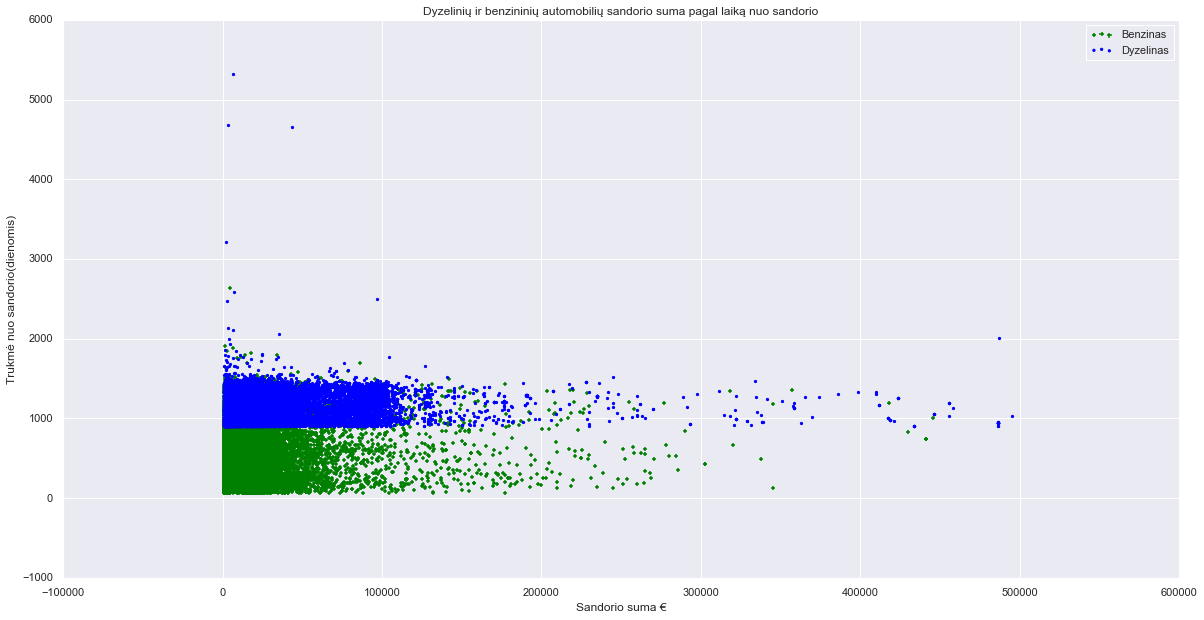

In [95]:
plt.figure(figsize=(20,10))
plt.xlabel('Sandorio suma €')
plt.ylabel('Trukmė nuo sandorio(dienomis)')
plt.scatter(df0['SANDORIO_SUMA'], df0['SANDORIO_DATA_DAYS'],color="green",marker='+', label='Benzinas')
plt.scatter(df1['SANDORIO_SUMA'], df1['SANDORIO_DATA_DAYS'],color="blue",marker='.', label='Dyzelinas')
plt.title('Dyzelinių ir benzininių automobilių sandorio suma pagal laiką nuo sandorio')
plt.legend()

### Pasirenkamas K artimiausių kaimynų klasifikatorius

In [96]:
X = fuel_data.drop(['DEGALAI'], axis='columns')
y = fuel_data['DEGALAI']

In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print(len(X_train))
print(len(X_test))



37043
6537


In [98]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [99]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
score   


0.8909285605017592

## Kokiu tikslumu galima nustatyti automobilio markę pagal pagaminimo datą, sandorio datą, galią, darbinį tūrį ir kainą?


In [100]:
brand_data = raw_data[raw_data['MARKE'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
brand_data = brand_data.drop(['PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA',  'DEGALAI', 'PIRM_REG_DATA_LT'], axis='columns')
brand_data = brand_data[
                          (brand_data['MARKE'] == 'VOLKSWAGEN') 
                        | (brand_data['MARKE'] == 'AUDI')
                        | (brand_data['MARKE'] == 'TOYOTA')
                        | (brand_data['MARKE'] == 'BMW')
                        | (brand_data['MARKE'] == 'OPEL')
                        | (brand_data['MARKE'] == 'MERCEDES BENZ')
                       ]



In [101]:
brand_data['SANDORIO_DATA'] = pd.to_datetime(brand_data['SANDORIO_DATA'], errors='coerce')
brand_data['PIRM_REG_DATA'] = pd.to_datetime(brand_data['PIRM_REG_DATA'], errors='coerce')
brand_data['SANDORIO_DATA_DAYS'] = (date.today() - brand_data['SANDORIO_DATA'].dt.date).dt.days
brand_data['PIRM_REG_DATA_DAYS'] = (date.today() - brand_data['PIRM_REG_DATA'].dt.date).dt.days

brand_data = brand_data[brand_data['PIRM_REG_DATA_DAYS'] > 0]
brand_data = brand_data[brand_data['SANDORIO_DATA_DAYS'] > 0]
brand_data = brand_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA'], axis='columns')
brand_data.head()

,MARKE,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
3,MERCEDES BENZ,3500.0,90.0,2874.0,1784,8098
7,VOLKSWAGEN,900.0,55.0,1781.0,1694,9344
13,VOLKSWAGEN,71245.0,103.0,1968.0,1599,1426
14,VOLKSWAGEN,71245.0,103.0,1968.0,1599,1426
15,BMW,78854.0,225.0,2979.0,1595,1420


In [102]:
X1 = brand_data.drop(['MARKE'], axis='columns')
y1 = brand_data['MARKE']

### Pasirenkamas atsitiktinių miškų klasifikatorius

In [103]:

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15)

print(len(X1_train))
print(len(X1_test))


52525
9270


In [104]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X1_train)
X1_train = scaling.transform(X1_train)
X1_test = scaling.transform(X1_test)

In [105]:
model1 = RandomForestClassifier(n_estimators=100, random_state=10)
model1.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [106]:
model1.score(X1_test, y1_test)

0.9598705501618123

## Kokiu tikslumu galima nustatyti automobilio kainą?

In [191]:
price_data = raw_data[raw_data['MARKE'].notnull() 
                     & raw_data['SANDORIO_SUMA'].notnull() 
                     & (raw_data['VALIUTA'] == 'EUR')
                     & raw_data['GALIA'].notnull()
                     & raw_data['DARBINIS_TURIS'].notnull()
                     & raw_data['PIRM_REG_DATA'].notnull()
                     & raw_data['SANDORIO_DATA'].notnull()
                    ]
price_data = price_data[
                          (price_data['MARKE'] == 'VOLKSWAGEN') 
                        | (price_data['MARKE'] == 'AUDI')
                        | (price_data['MARKE'] == 'TOYOTA')
                        | (price_data['MARKE'] == 'BMW')
                        | (price_data['MARKE'] == 'OPEL')
                        | (price_data['MARKE'] == 'MERCEDES BENZ')
                       ]


price_data = price_data[(price_data['DEGALAI'] == 'Dyzelinas') | (price_data['DEGALAI'] == 'Benzinas')]

price_data = price_data.drop(['PASKUTINES_REG_DATA', 'KILMES_SALIS', 'VALIUTA',  'PIRM_REG_DATA_LT'], axis='columns')

price_data.sort_values(by=['SANDORIO_SUMA' ,'DARBINIS_TURIS'], ascending=False).head(10)

,MARKE,DEGALAI,SANDORIO_SUMA,SANDORIO_DATA,GALIA,DARBINIS_TURIS,PIRM_REG_DATA
143729,MERCEDES BENZ,Dyzelinas,9120980.0,2016-04-08,310.0,12809.0,2016-04-19
596034,MERCEDES BENZ,Dyzelinas,9033860.0,2018-05-02,310.0,12809.0,2018-08-24
566501,MERCEDES BENZ,Dyzelinas,8650653.0,2017-10-27,330.0,12809.0,2017-10-28
581100,MERCEDES BENZ,Dyzelinas,8576480.0,2018-02-12,330.0,12809.0,2018-03-06
636667,MERCEDES BENZ,Dyzelinas,4774502.0,2018-12-13,190.0,2987.0,2017-05-11
659913,VOLKSWAGEN,Dyzelinas,3513219.0,2019-04-23,75.0,1968.0,2017-02-14
149359,AUDI,Dyzelinas,3016807.0,2016-06-23,230.0,2967.0,2013-04-17
653198,TOYOTA,Benzinas,1919092.0,2019-03-21,129.0,1987.0,2019-04-10
673101,BMW,Dyzelinas,1605011.0,2019-06-30,190.0,2993.0,2013-05-28
638783,MERCEDES BENZ,Dyzelinas,1146114.0,2018-12-31,375.0,12809.0,2019-01-08


In [174]:
price_data['SANDORIO_DATA'] = pd.to_datetime(price_data['SANDORIO_DATA'], errors='coerce')
price_data['PIRM_REG_DATA'] = pd.to_datetime(price_data['PIRM_REG_DATA'], errors='coerce')
price_data['SANDORIO_DATA_DAYS'] = (date.today() - price_data['SANDORIO_DATA'].dt.date).dt.days
price_data['PIRM_REG_DATA_DAYS'] = (date.today() - price_data['PIRM_REG_DATA'].dt.date).dt.days
price_data = price_data[price_data['PIRM_REG_DATA_DAYS'] > 0]
price_data = price_data[price_data['SANDORIO_DATA_DAYS'] > 0]
price_data = price_data.drop(['SANDORIO_DATA', 'PIRM_REG_DATA'], axis='columns')


In [175]:
df0 = price_data[price_data['DEGALAI'] == 'Dyzelinas']
df1 = price_data[price_data['DEGALAI'] == 'Benzinas']

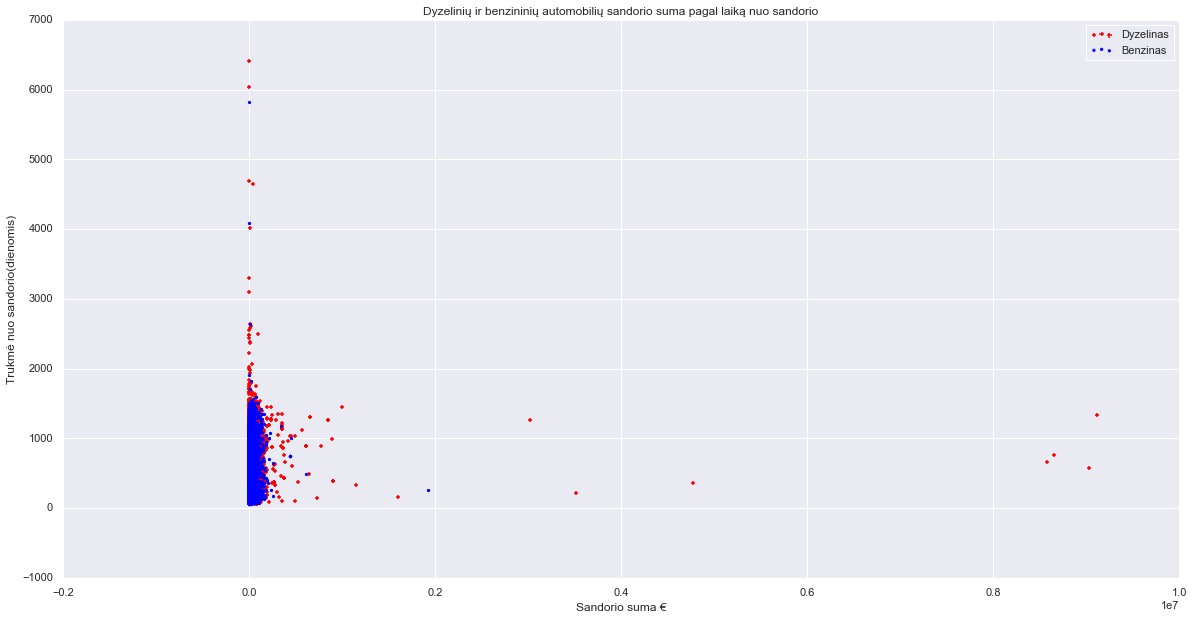

In [176]:

plt.figure(figsize=(20,10))
plt.xlabel('Sandorio suma €')
plt.ylabel('Trukmė nuo sandorio(dienomis)')

plt.scatter(df0['SANDORIO_SUMA'], df0['SANDORIO_DATA_DAYS'],color="red",marker='+', label='Dyzelinas')
plt.scatter(df1['SANDORIO_SUMA'], df1['SANDORIO_DATA_DAYS'],color="blue",marker='.', label='Benzinas')
plt.title('Dyzelinių ir benzininių automobilių sandorio suma pagal laiką nuo sandorio')
plt.legend()

Text(0.5, 1.0, 'Dyzelino populiarumas pagal valstybę')

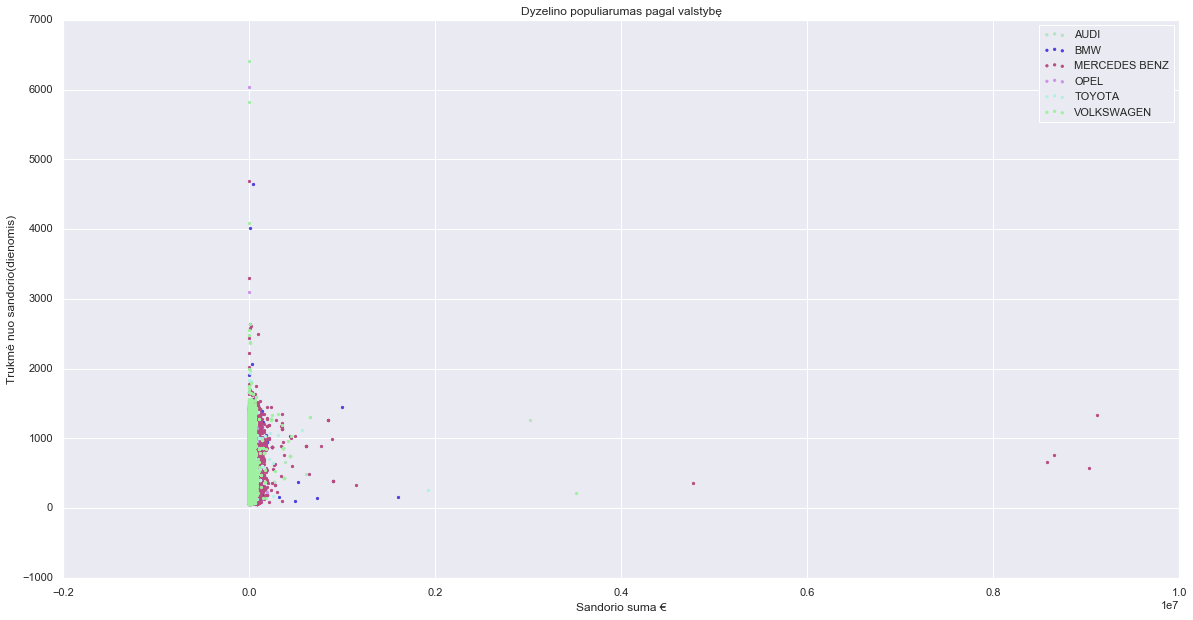

In [177]:
grouped_marke = price_data.groupby(['MARKE'])
plt.figure(figsize=(20,10))

for key, item in grouped_marke:
    plt.scatter( 'SANDORIO_SUMA', 'SANDORIO_DATA_DAYS', data=grouped_marke.get_group(key), color=np.random.rand(3,), marker='.', label=key)
plt.legend()
plt.xlabel('Sandorio suma €')
plt.ylabel('Trukmė nuo sandorio(dienomis)')
plt.title('Dyzelino populiarumas pagal valstybę')

Text(0.5, 1.0, 'Kainos priklausomybė nuo automobilio darbinio tūrio')

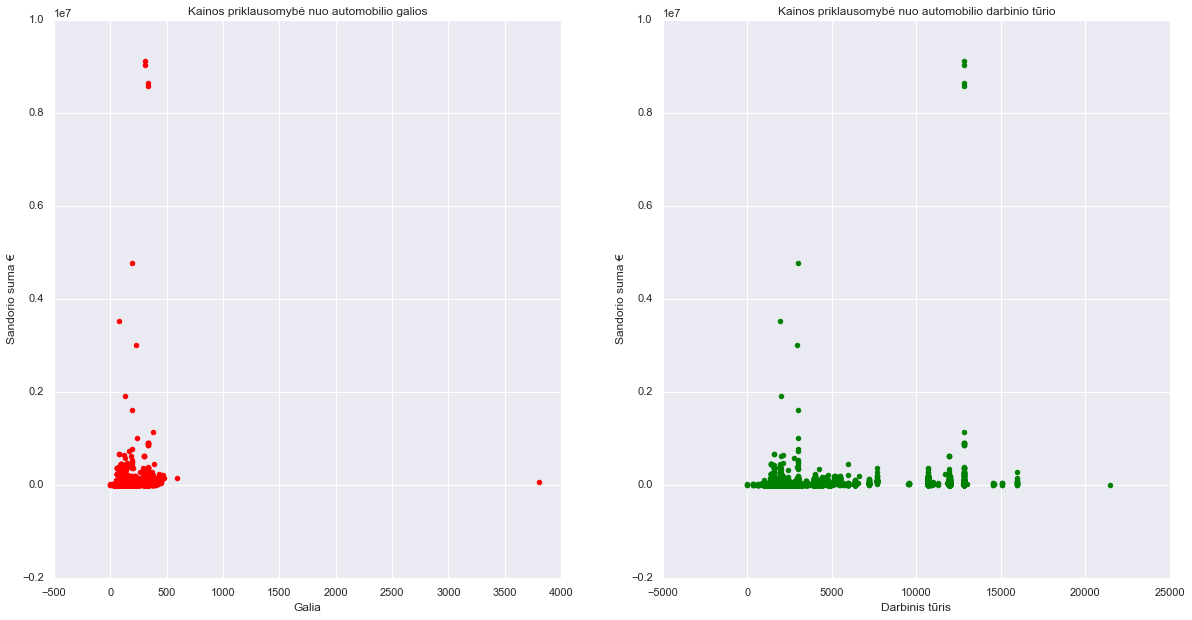

In [178]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.xlabel('Galia')
plt.ylabel('Sandorio suma €')
plt.title('Kainos priklausomybė nuo automobilio galios')
plt.scatter(price_data['GALIA'], price_data['SANDORIO_SUMA'],color="red",)


plt.subplot(1,2,2)
plt.scatter(price_data['DARBINIS_TURIS'], price_data['SANDORIO_SUMA'],color="green")
plt.xlabel('Darbinis tūris')
plt.ylabel('Sandorio suma €')
plt.title('Kainos priklausomybė nuo automobilio darbinio tūrio')

#### Nuspręsta kainų prognozę vykdyti nuo 1000 iki 50000 €, kadangi pigesnių ir brangesnių automobilių yra labai nedaug duomenų ir jie stipriai paveikia bendrą tikslumą.


In [179]:
price_data = price_data[price_data['SANDORIO_SUMA'] > 1000]
price_data = price_data[price_data['SANDORIO_SUMA'] < 50000]
price_data.head()

,MARKE,DEGALAI,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS
3,MERCEDES BENZ,Dyzelinas,3500.0,90.0,2874.0,1784,8098
20,BMW,Benzinas,42814.8,135.0,1997.0,1558,1417
21,VOLKSWAGEN,Dyzelinas,1115.5,80.0,2460.0,1545,7240
22,BMW,Benzinas,21700.0,110.0,1499.0,1542,1412
24,VOLKSWAGEN,Dyzelinas,20050.0,81.0,1968.0,1539,1412


#### Taip pat pastebėta, kad duomenų rinkinyje yra automobilių, kurių darbinis tūris yra netoli 20L šie automobiliai greičiausiai yra sunkesvoriai, todėl nuspręsta naudoti duomenis nuo 0 iki 5l (5000)

In [180]:
price_data = price_data[price_data['DARBINIS_TURIS'] < 4000]


#### Sumaišome duomenis bei pasirenkame pirmus 10 tūkstančių.

In [181]:
from sklearn.utils import shuffle
price_data = shuffle(price_data)
price_data = price_data.head(10000)

### One hot encoding

In [182]:
X2 = price_data
X2 = pd.get_dummies(data=X2)
X2.head()

,SANDORIO_SUMA,GALIA,DARBINIS_TURIS,SANDORIO_DATA_DAYS,PIRM_REG_DATA_DAYS,MARKE_AUDI,MARKE_BMW,MARKE_MERCEDES BENZ,MARKE_OPEL,MARKE_TOYOTA,MARKE_VOLKSWAGEN,DEGALAI_Benzinas,DEGALAI_Dyzelinas
679702,5461.0,103.0,1956.0,117,1657,0,0,0,1,0,0,0,1
684823,21970.0,85.0,1197.0,89,73,0,0,0,0,1,0,1,0
628257,1500.0,120.0,2496.0,407,6115,1,0,0,0,0,0,0,1
20,42814.8,135.0,1997.0,1558,1417,0,1,0,0,0,0,1,0
632534,16115.7,96.0,1498.0,381,380,0,0,0,0,0,1,1,0


In [183]:
X2 = X2.drop([ 'SANDORIO_SUMA'], axis='columns')
y2 = price_data['SANDORIO_SUMA']

In [184]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

print(len(X2_train))
print(len(X2_test))


8000
2000


In [185]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X2_train)
X2_train = scaling.transform(X2_train)
X2_test = scaling.transform(X2_test)

In [186]:


gradient_model = GradientBoostingRegressor(loss ='ls', max_depth=5)

gradient_model.fit (X2_train, y2_train)
score = gradient_model.score(X2_test, y2_test)
predicted = gradient_model.predict(X2_test)
difference = y2_test - predicted

In [187]:
rmse = np.sqrt(mean_squared_error(y2_test, predicted))
scores = cross_val_score(gradient_model, X2, y2, cv=5)

In [188]:

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

print('Variance score: %.2f' % r2_score(y2_test, predicted))


Cross Validation Scores:
[0.87892828 0.89623291 0.89533919 0.88315165 0.8993059 ]

Mean Score:
0.8905915863139302

RMSE:
4119.483703796175
Variance score: 0.89


## Išvados, pastebėjimai

1. Prognozuojant kainą gerą rezultatą pavyko pasiekti tik tada, kai buvo nuspręsta naudoti automobilių, kurie kainuoja nuo 1000 iki 50000 € duomenis.
1. Taip pat rezultatas šiek tiek pagerėjo (apie vidutinis rezultatas pagerėjo apie 0.03), kai buvo nuspręsta naudoti tik tų automobilių duomenis, kurių darbinis tūris neviršija 5l (dažniausiai tik sportinių automobilių darbinis tūris yra didesnis nei 5l).
1. Kainų prognozei tego panaudoti "One hot encoding", kadangi buvo naudojami kuro bei markės duomenys.
